# Mask R-CNN
## Deep Learning Hochschule München, WiSe 2020/21

Ahmet Sahin, Oliver Scholz, Josef Kaffl

[matterport/Mask_RCNN GitHub-Repository](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb) als Vorlage für dieses Notebook.


Voraussetzungen:
* Python 3.6
* Tensorflow 1.13.1
* Keras 2.2.4
* [matterport/Mask_RCNN GitHub-Repository](https://github.com/matterport/Mask_RCNN) klonen, in das Verzeichnis wechseln und `python setup.py install` ausführen.

[Hier gibt es die vortrainierten Gewichte](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# should suppress warning:
# /usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is 
#   not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 
#   0.19 a ValueError will be raised instead of this warning.
#     order = _validate_interpolation_order(image.dtype, order)

import json
import boto3
import io
import random
from os import listdir
import numpy
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from mrcnn import visualize
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import mold_image
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/usr/local/lib/python3.6/dist-packages/google/protobuf/__init__.py:37: UserWarning: Module mrcnn was already imported from /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/__init__.py, but /root is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)
Using TensorFlow backend.


In [2]:
!nvidia-smi

Thu Feb  4 21:28:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0    18W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow
tensorflow.__version__

'1.13.1'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 220634646728095128
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8526359073179294295
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8893670982480084184
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14949928141
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9822924389860807915
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [2]:
class BeeDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train = True, is_sample = False):
        self.add_class("dataset", 1, "bee")
        
        aws_s3 = boto3.client('s3')
        aws_s3.list_objects_v2(
            Bucket='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb', 
            Prefix='bee-labeling-2k-batch-01/manifests/output'
        )

        s3r = boto3.resource('s3')
        bucket = s3r.Bucket('labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb')

        # downloading folder 
        prefix = 'bee-labeling-2k-batch-01/manifests/output'
        for object in bucket.objects.filter():
            if object.key.endswith('.png'):
                image_id = object.key[:-4]
                
                if not is_sample:
                    # für dieses Bild gibt es keine Bounding Boxes
                    if image_id == '2020_06_26_16_43_16':
                        continue
                else:
                    if image_id != '2020_06_26_16_43_16':
                        continue
                
                tmp = image_id.replace('_', '')
                if is_train and int(tmp) > 20200626180000:
                    continue
                if not is_train and int(tmp) <= 20200626180000:
                    continue
                
                image_path = prefix + '/' + object.key
                
                self.add_image('dataset', image_id=image_id, path=image_path, annotation=object.key)
    
    def extract_boxes(self, imgname):
        # imgname ist der Dateipfad des Bildes hier
        
        aws_s3 = boto3.client('s3')
        aws_s3.list_objects_v2(
            Bucket='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb', 
            Prefix='bee-labeling-2k-batch-01/manifests/output'
        )
        aws_s3.download_file('labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb', 
                     'bee-labeling-2k-batch-01/manifests/output/output.manifest', 'output.manifest')
        
        with open('output.manifest') as f:
            txt = f.readlines()
        txt = [x.strip() for x in txt] # delete \n

        for t in txt:
            fn = t[80:] # always 80 characters before filename appears
            filename = fn[0:23] # filename always 23 character long
            if filename != imgname:
                # wenn es nicht das richtige Bild ist, weiter...
                continue
            boxes = list()
            # read json and parse through dictonaries
            tjson = json.loads(t)
            tjson = tjson['bee-labeling-2k-batch-01']
            tjson = tjson['annotations']
            vals = []
            # iterate through all bees
            for id in tjson:
                coords = [id['top'], id['left'], id['height'], id['width']]
                boxes.append(coords)
        return boxes, 1613, 371 # boxes, width, height
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[0], box[0] + box[2]
            col_s, col_e = box[1], box[1] + box[3]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('bee'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        
        s3r = boto3.resource('s3')
        bucket = s3r.Bucket('labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb')
        
        object = bucket.Object(self.image_info[image_id]['annotation'])
        file_stream = io.BytesIO()
        object.download_fileobj(file_stream)
        image = mpimg.imread(file_stream, format="PNG")
        
        return image

In [3]:
train_set = BeeDataset()
train_set.load_dataset('bee', is_train = True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 1434


In [4]:
test_set = BeeDataset()
test_set.load_dataset('bee', is_train = False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 565


In [5]:
sample_set = BeeDataset()
sample_set.load_dataset('bee', is_sample = True)
sample_set.prepare()
print('Sample: %d' %len(sample_set.image_ids))

Sample: 1


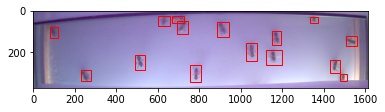

In [9]:
# define image id
image_id = 250
# load the image
image = train_set.load_image(image_id)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)

pyplot.imshow(image)
# plot mask
#for j in range(mask.shape[2]):
    # print(mask[j])
    # print(mask)
#    pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.001)
#pyplot.show()

# extract bounding boxes from the masks
bbox  = extract_bboxes(mask)
ax = pyplot.gca()
for box in bbox:
    y1, x1, y2, x2 = box
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)
pyplot.show()

In [6]:
class BeeConfig(Config):
    NAME = 'bee_cfg'
    # 2 Klassen: Background + Biene
    NUM_CLASSES = 1 + 1
    IMAGES_PER_GPU = 2
    STEPS_PER_EPOCH = 1000
    LEARNING_RATE = 0.002
    LEARNING_MOMENTUM = 0.95
    WEIGHT_DECAY = 0.001

config = BeeConfig()

In [7]:
model = MaskRCNN(mode = 'training', model_dir='./', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Instructions for updating:
Colocations handled automatically by placer.

Starting at epoch 0. LR=0.002

Checkpoint Path: ./bee_cfg20210204T1827/mask_rcnn_bee_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mr

/root/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/root/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
1000/1000 [==============================] - 1592s 2s/step - loss: 2.3822 - rpn_class_loss: 0.3527 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.4585 - mrcnn_bbox_loss: 0.5490 - mrcnn_mask_loss: 0.4868 - val_loss: 2.1366 - val_rpn_class_loss: 0.3147 - val_rpn_bbox_loss: 0.4921 - val_mrcnn_class_loss: 0.3733 - val_mrcnn_bbox_loss: 0.4884 - val_mrcnn_mask_loss: 0.4680
Epoch 2/5
1000/1000 [==============================] - 2019s 2s/step - loss: 1.7759 - rpn_class_loss: 0.1807 - rpn_bbox_loss: 0.4450 - mrcnn_class_loss: 0.3283 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.4092 - val_loss: 1.6583 - val_rpn_class_loss: 0.1231 - val_rpn_bbox_loss: 0.4535 - val_mrcnn_class_loss: 0.3054 - val_mrcnn_bbox_loss: 0.4063 - val_mrcnn_mask_loss: 0.3699
Epoch 3/5
1000/1000 [==============================] - 2082s 2s/step - loss: 1.6233 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.2936 - mrcnn_bbox_loss: 0.3608 - mrcnn_mask_loss: 0.3741 - val_loss: 1.5341 - val_rpn_c

# Vorhersagen treffen

In [10]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "bee_cfg"
    # number of classes (background + bee)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [11]:
predCfg = PredictionConfig()
predCfg.display()
model = modellib.MaskRCNN(mode="inference", model_dir='./', config=predCfg)

# load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: dataset.2020_06_27_07_59_05 (477) bee-labeling-2k-batch-01/manifests/output/2020_06_27_07_59_05.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (46,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (46, 4)               min:   45.00000  max:  986.00000  int32
gt_mask                  shape: (1024, 1024, 46)      min:    0.00000  max:    1.00000  uint8


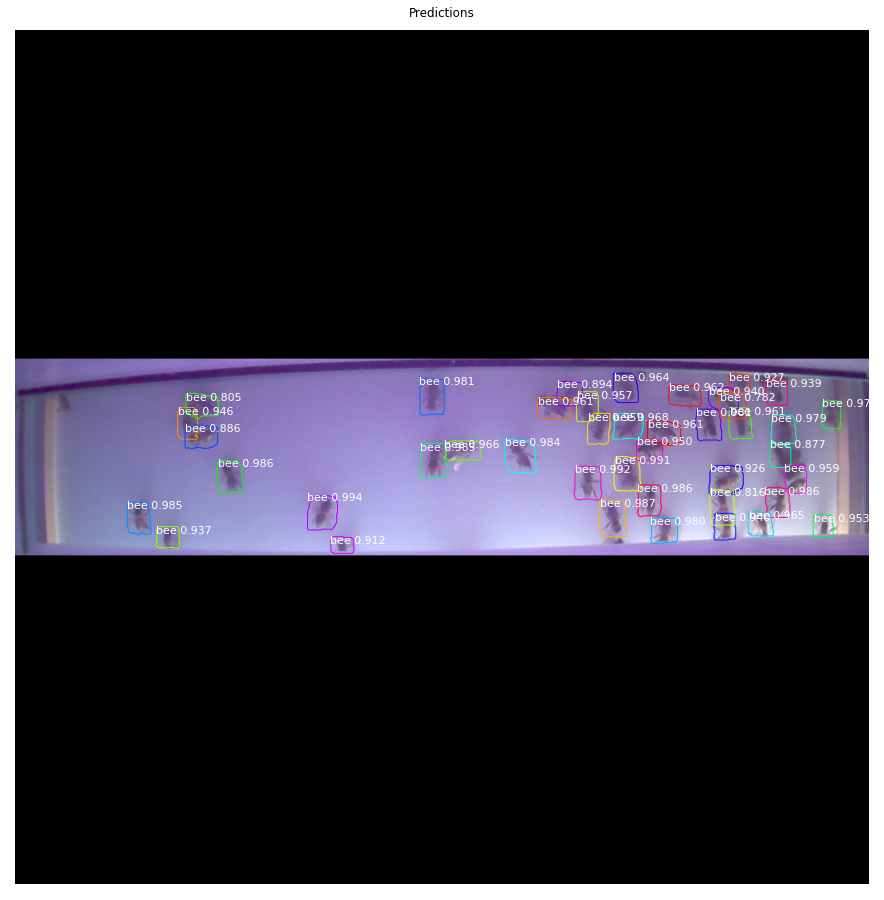

In [13]:
# Zufällig ein Bild aus dem Test-Set auswählen und eine Prediction durchführen
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, predCfg, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], test_set.class_names, r['scores'], ax=ax,
                            title="Predictions", show_mask=False)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

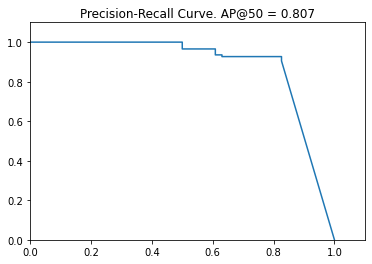

In [14]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [18]:
# Zufällig 100 Bider auswählen und die mean average precision berechnen

# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(test_set, predCfg,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = numpy.random.choice(test_set.image_ids, 100)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", numpy.mean(APs))

mAP @ IoU=50:  0.7963636828534689


image ID: dataset.2020_06_26_16_43_16 (0) bee-labeling-2k-batch-01/manifests/output/2020_06_26_16_43_16.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    0.95201  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.94799  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (0,)                  min:             max:             int32
gt_bbox                  shape: (0, 4)                min:             max:             int32
gt_mask                  shape: (1024, 1024, 0)       min:             max:             uint8


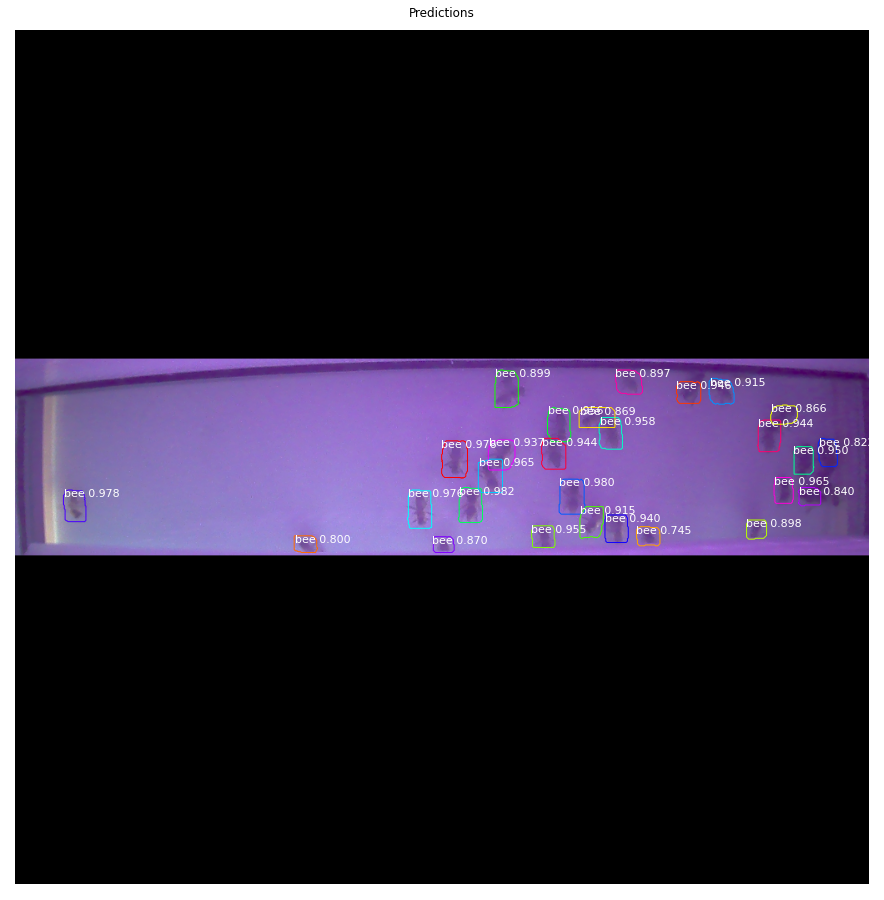

In [19]:
# Für das hier dargestellte Bild liegen keine Label-Daten vor
image_id = random.choice(sample_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(sample_set, predCfg, image_id, use_mini_mask=False)
info = sample_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, sample_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], sample_set.class_names, r['scores'], ax=ax,
                            title="Predictions", show_mask=False)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)